In [1]:
import numpy as np
from matplotlib import pyplot as plt
from util import make_rotation_matrix
import tensorflow as tf
%matplotlib inline

##Load data

In [2]:
# load images, from which the image coordinates were picked
# 4-dimensional tensor: (image,ydim,xdim,color)
images = np.load("images.npy") # 4 dime

# load image coordinates, picked by hand
# 3-dimensional tensor (image,object class,spatial dim)
# for example the imagecoords[0][1] would return the (x,y) coordiante
# of 1st object from the 0th image.
imagecoords = np.load("imagecoords.npy")

# load mask of objects not visible in the images
# same dimensions as imagecoords
observed_mask = np.load("observed_mask.npy")

# useful things
aspect_ratio = 2688.0/1520.0 #dimensions of the original images
objclass_colors = ("red","green","blue","yellow","orange","purple")

##Make a rough guess about camera and object locations

In [3]:
# make a rough guess about the camera positions and orientations

camera_pos = np.array([[150,100,50],
              [150,100,-100],
              [-20,150,-400],
              [-150,100,-50],
              [0,200,30],
              [100,50,-10]],dtype=np.float32) # rough guess
camera_orientation = np.array([[0,45,0],
                      [0,100,0],
                      [0,-170,0],
                      [0,-90,0],
                      [-90,0,0],
                      [0,90,0]],dtype=np.float32) # rough guess; note, in degrees

camera_orientation = np.pi * camera_orientation/180 #convert to radians

obj_pos = np.array( [[75,20,-50],
             [75,20,-45],
             [-65,20,-45],
             [85,5,-50],
             [10,30,-100],
             [10,0,-100]],dtype=np.float32 )

##Visualize initial guess for cameras and objects

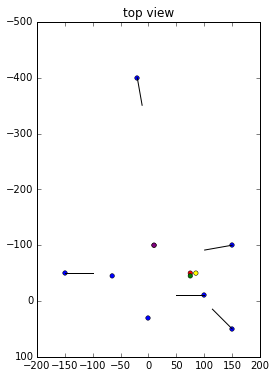

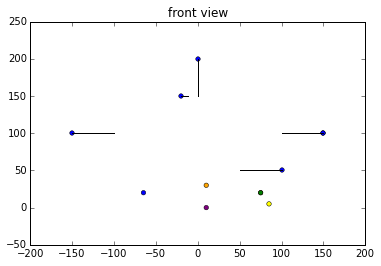

In [5]:

look_normals = []
for alpha,beta,gamma in camera_orientation:
    A = make_rotation_matrix( -alpha,-beta,-gamma )
    looky = [0,0,-50]
    look_normals.append( np.dot(np.linalg.inv(A),looky) )
look_normals = np.array(look_normals)
look_endpoints = camera_pos+look_normals

# looking at the whole scene from the top
cx,cz = camera_pos.T[[0,2]]
px,pz = obj_pos.T[[0,2]]
plt.figure(figsize=(4,6))
plt.xlim(-200,200)
plt.ylim(-500,100)
plt.gca().invert_yaxis()
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=objclass_colors,lw=0.5)
plt.title("top view")

for i in range(6):
    cx,cy,cz = camera_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cz,lz],c="black")
plt.show()

# looking at the whole scene from the front
cx,cz = camera_pos.T[[0,1]]
px,pz = obj_pos.T[[0,1]]
# plt.figure(figsize=(4,6))
# plt.xlim(-200,200)
# plt.ylim(-500,100)
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=("red","green","blue","yellow","orange","purple"),lw=0.5)
plt.title("front view")

for i in range(6):
    cx,cy,cz = camera_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cy,ly],c="black")
plt.show()

##Set up Theano computation graph for projection errors

I started in TensorFlow, but Theano has Jacobian computation and TF does not.

In [7]:
from theano import tensor as T
import theano as th
from theano import gradient

# # camera orientation variables
# homo_camera_pos = np.hstack( (camera_pos, np.ones( (nimages,1) )) )
# tfcam_pos = tf.Variable(np.array(camera_pos,dtype=np.float32)*0.001) #scale camera position
# tfcam_orient = tf.Variable(camera_orientation)

cam_pos = T.fmatrix('cam_pos')

# scale camera position
scaled_cam_pos = cam_pos*1.0

# pad the matrix with ones to make it into homogeneous coordinates
ncams = T.shape(cam_pos)[0]
ones_col = T.alloc(1,ncams,1)
homo_cam_pos = T.concatenate([scaled_cam_pos,ones_col],axis=1)

thcam_orient = T.fmatrix('cam_orient')

# object positions
tfobj_pos = T.fmatrix('obj_pos')

# scale object posiion
scaled_obj_pos = tfobj_pos*1.0

# turn object positions into homogeneous coordinates
nobjs = T.shape(tfobj_pos)[0]
ones_col = T.alloc(1,nobjs,1)
homo_obj_pos = T.concatenate([scaled_obj_pos,ones_col],axis=1)

# image coordinates
# transpose the dimensions from (image,object class,spatial dim) to (image,spatial dim,object_class)
thimagecoords = T.ftensor3('imagecoords')
thsideways_imagecoords = thimagecoords.dimshuffle(0,2,1)

# observed points mask
# transpose the dimensions from (image,object class,spatial dim) to (image,spatial dim,object_class)
#tfobserved_mask = tf.cast( tf.transpose( tf.constant(observed_mask), (0,2,1) ), tf.float32 )
thobserved_mask = T.ftensor3('observed_mask')
thsideways_observed_mask = thobserved_mask.dimshuffle(0,2,1)

# focal length!
thfocal_length = T.fscalar('focal_length')

# take an [n,3] stack of num_images euler angle orientation and return
# [n,3,3] stack of rotation matrices
def thmake_rotation_matrix(theta):
    a = theta[:,0]
    b = theta[:,1]
    c = theta[:,2]
    
    ncameras = theta.shape[0]
    
    zero = T.zeros_like(a)
    one = T.ones_like(a)
    
    A_x = T.stacklists([[one,zero,zero,zero],
                        [zero,T.cos(a),-T.sin(a),zero],
                        [zero,T.sin(a),T.cos(a),zero],
                        [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    A_y = T.stacklists([[T.cos(b),zero,T.sin(b),zero],
                        [zero,one,zero,zero],
                        [-T.sin(b),zero,T.cos(b),zero],
                        [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    A_z = T.stacklists([[T.cos(c),-T.sin(c),zero,zero],
                        [T.sin(c),T.cos(c),zero,zero],
                        [zero,zero,one,zero],
                        [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    A = T.batched_dot(T.batched_dot(A_x,A_y),A_z)
    
    return A

def thmake_translation_matrix(pos):
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    
    zero = T.zeros_like(x)
    one = T.ones_like(x)
    
    A = T.stacklists([[one,zero,zero,x],
                      [zero,one,zero,y],
                      [zero,zero,one,z],
                      [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    return A

rotation_operators = thmake_rotation_matrix(-thcam_orient)
translation_operators = thmake_translation_matrix(-homo_cam_pos)
transform_operators = T.batched_dot(rotation_operators,translation_operators)

#points in camera reference frame
thbroadcast_pos = T.shape_padleft( homo_obj_pos.transpose(), 1 ).repeat(ncams,axis=0)
thcam_transform_pts = T.batched_dot(transform_operators,thbroadcast_pos)

# points projected into perspective
# we could use a projection matrix but this is actually pretty simple
thdepth = T.shape_padleft(thcam_transform_pts[:,2,:]).dimshuffle(1,0,2)
thbigness = thfocal_length/-thdepth
thprojpoint = (thcam_transform_pts*thbigness)[:,0:2,:]

# find the loss
R = thsideways_observed_mask*(thprojpoint - thsideways_imagecoords)
#thloss = T.square( thresiduals ).mean()

Jf = gradient.jacobian(thprojpoint.flatten(),
                      [cam_pos,thcam_orient,tfobj_pos], 
                      consider_constant=[thfocal_length])

In [8]:
# compile functions from expressions 

R_fun = th.function([cam_pos,thcam_orient,tfobj_pos,thfocal_length,thimagecoords,thobserved_mask],R)
Jf_fun = th.function([cam_pos,thcam_orient,tfobj_pos,thfocal_length],Jf)
projpoint_fun = th.function([cam_pos,thcam_orient,tfobj_pos,thfocal_length],thprojpoint)

## Implement Levenberg–Marquardt algorithm

In principle one could compile all of this into the theano graph, but that's premature optimization for now.

In [10]:
# array-shaping boilerplate

def flatten_jacobian(J):
    n = J[0].shape[0]
    flattened_js = []
    for j in J:
        flattened_js.append( j.reshape(n,-1) )
    return np.hstack(flattened_js)

def unflatten_delta_params(flat_params, like_arrays):
    i = 0
    delta_params = []
    for ary in like_arrays:
        rows,cols = ary.shape
        n = rows*cols
        delta_params.append( flat_params[i:i+n].reshape(rows,cols) )
        i += n
    return delta_params

In [11]:
# scale camera and object points into the same
# approximate range as the camera orientation's
# radian euler angles
points_scale = 0.001

xcampos = camera_pos.copy()*points_scale
xcamorient = camera_orientation.copy()
xobjpos = obj_pos.copy()*points_scale

In [12]:
R_0 = R_fun( xcampos,
             xcamorient,
             xobjpos,
             0.8,
             imagecoords.astype(np.float32),
             observed_mask.astype(np.float32) ).flatten()
meanloss = np.sum( np.square( R_0 ) )/R_0.size

losstrace = []

lam = 0.003
max_iters = 2000
i=0
while True:
    losstrace.append( meanloss )
    J_0 = flatten_jacobian( Jf_fun( xcampos, xcamorient, xobjpos, 0.8 ) )

    if i%10==0:
        print meanloss

    approx_hessian = np.dot(J_0.T,J_0)
    I = np.identity(approx_hessian.shape[0])

    loss_grad = np.dot(-J_0.T,R_0)

    # approx_hessian . delta = loss_grad
    # solve for delta, using pseudo-inverse
    delta = np.dot( np.linalg.pinv(approx_hessian + lam*I), loss_grad ).astype(np.float32)

    dcampos, dcamorient, dobjpos = unflatten_delta_params(delta, (xcampos,xcamorient,xobjpos) )
    
    # try out old paramaters plus the delta
    R_1 = R_fun( xcampos+dcampos,
                      xcamorient+dcamorient,
                      xobjpos+dobjpos,
                      0.8,
                      imagecoords.astype(np.float32),
                      observed_mask.astype(np.float32) ).flatten()
    meanloss_1 = np.sum( np.square( R_1 ) )/R_1.size
    
    # if it's better, use it and continue iterating
    if meanloss_1 < meanloss:
        xcampos += dcampos
        xcamorient += dcamorient
        xobjpos += dobjpos
        
        # check if we've converged
        if abs(meanloss_1-meanloss)/meanloss < 0.00001:
            print meanloss_1, abs(meanloss_1-meanloss)/meanloss
            break
        
        R_0 = R_1
        meanloss = meanloss_1
        
        lam *= 0.95
    else:
        lam *= 1.5
        print "DIVERGE, new lambda:%s"%lam
    
    i += 1
    if i>max_iters:
        break

0.184608777364
DIVERGE, new lambda:0.00330791350781
DIVERGE, new lambda:0.00496187026172
9.67413652688e-05
6.12380034808e-05
5.62874871927e-05
5.2222257687e-05
4.88369259983e-05
4.60577009815e-05
4.38079393158e-05
4.20072400529e-05
4.05774723428e-05
3.94478233324e-05
3.85568321993e-05
3.78527361641e-05
3.7292458324e-05
3.68405631485e-05
3.64666694723e-05
3.61413371542e-05
3.58287943527e-05
3.54576429042e-05
DIVERGE, new lambda:8.48818428272e-07
3.48807209068e-05
3.30122452902e-05
DIVERGE, new lambda:5.89875200725e-07
DIVERGE, new lambda:6.84651278737e-07
2.9370149908e-05
2.33449003038e-05
DIVERGE, new lambda:3.87533439768e-07
1.8498372002e-05
DIVERGE, new lambda:5.24623394086e-07
1.45822284847e-05
1.13674242231e-05
8.96541718652e-06
7.18210018628e-06
DIVERGE, new lambda:1.01130725638e-07
6.00274991787e-06
DIVERGE, new lambda:8.19705116564e-08
5.07362427824e-06
DIVERGE, new lambda:9.51408290353e-08
4.35230160494e-06
3.71366250975e-06
DIVERGE, new lambda:5.3852601877e-08
3.25273584975e-0

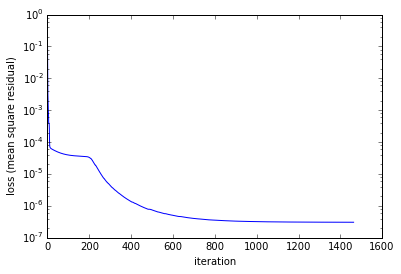

In [14]:
# plot the loss

plt.semilogy()
plt.xlabel("iteration")
plt.ylabel("loss (mean square residual)")
plt.plot( losstrace )

Within just a few iterations, the LM algorithm drops the loss by four orders of magnitude. It levels out into a saddlepoint, falls off the side of the saddlepoint, and converges in what is hopefully a local minima.

##Visualize the result

In [15]:
solved_cam_pos = xcampos/points_scale
solved_cam_orient = xcamorient
solved_obj_pos = xobjpos/points_scale

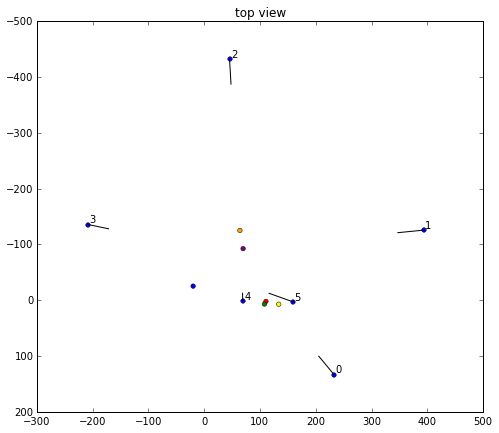

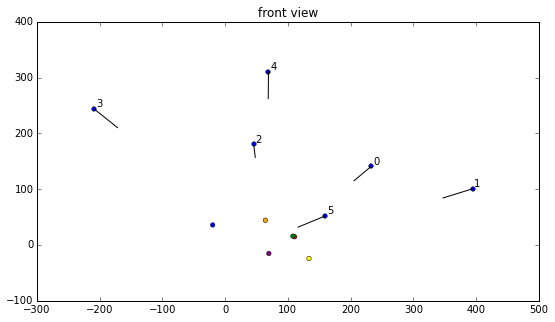

In [16]:
look_normals = []
for alpha,beta,gamma in solved_cam_orient:
    A = make_rotation_matrix( -alpha,-beta,-gamma )
    looky = [0,0,-50]
    look_normals.append( np.dot(np.linalg.inv(A),looky) )
look_normals = np.array(look_normals)
look_endpoints = solved_cam_pos+look_normals

# looking at the whole scene from the top
cx,cz = solved_cam_pos.T[[0,2]]
px,pz = solved_obj_pos.T[[0,2]]
plt.figure(figsize=(8,7))
plt.xlim(-300,500)
plt.ylim(-500,200)
plt.gca().invert_yaxis()
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=objclass_colors,lw=0.5)
plt.title("top view")

for i in range(6):
    cx,cy,cz = solved_cam_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cz,lz],c="black")
    plt.text(cx+4,cz-4,str(i))
plt.show()

# looking at the whole scene from the front
cx,cz = solved_cam_pos.T[[0,1]]
px,pz = solved_obj_pos.T[[0,1]]
plt.figure(figsize=(9,5))
plt.xlim(-300,500)
plt.ylim(-100,400)
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=("red","green","blue","yellow","orange","purple"),lw=0.5)
plt.title("front view")

for i in range(6):
    cx,cy,cz = solved_cam_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cy,ly],c="black")
    plt.text(cx+4,cy+4,str(i))
plt.show()

##Plot observed image coordinates vs. coordinates predicted by fit model

camera 0


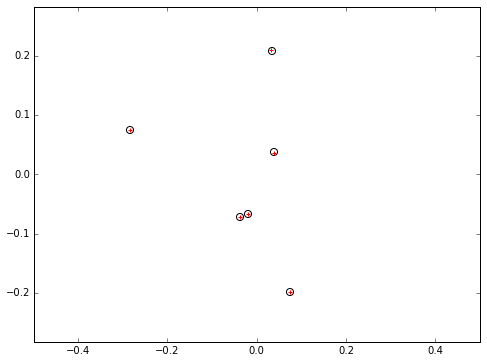

camera 1


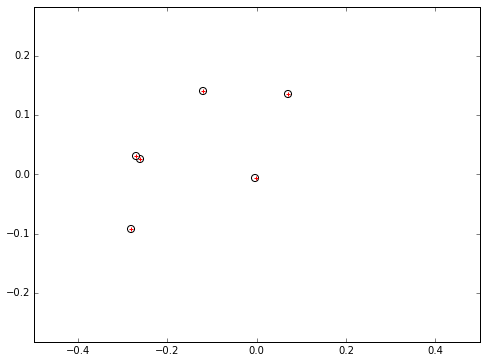

camera 2


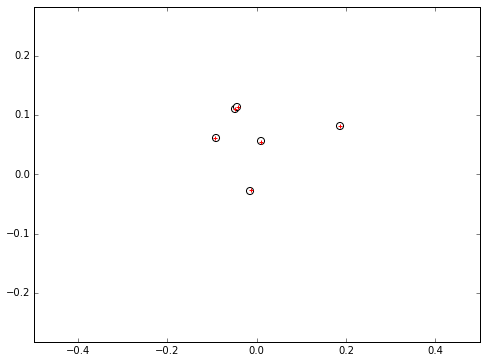

camera 3


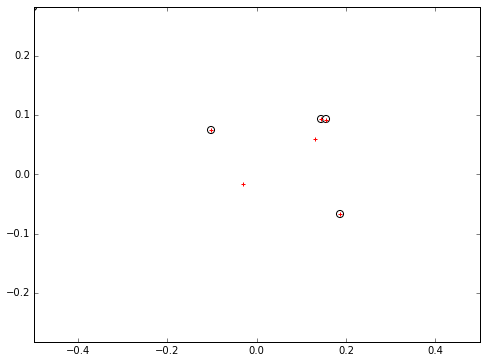

camera 4


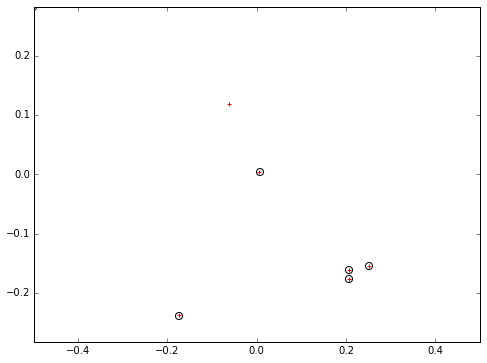

camera 5


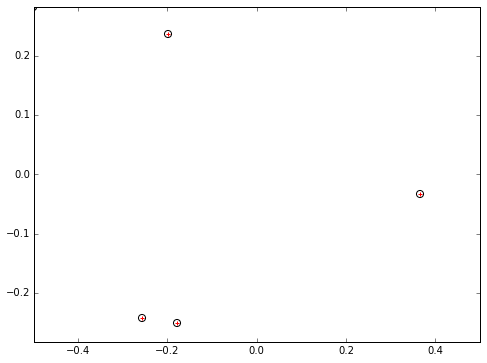

In [18]:
projpoint_val = projpoint_fun( solved_cam_pos, solved_cam_orient, solved_obj_pos, 0.8 )

for i in range(6):
    print "camera %d"%i
    plt.figure(figsize=(8,6))
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5/aspect_ratio,0.5/aspect_ratio)
    plt.scatter( *imagecoords[i].T, c="white", s=50 )
    plt.scatter( *projpoint_val[i], marker="+",c="red" )
    plt.show()